#### Predicting claim frequencies (expected claim count per unit of exposure) expressed as rate. Is the base for key calculations: pricing, resrving, ruin probabilities and reinsurance.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

In [32]:
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12.,6.)})
sns.set_style("whitegrid")

In [3]:
claimsdf = pd.read_csv('/home/julian/Cursos/Ironhack/Proyectos/ProyectoFinal/freMTPL2freq.csv')

In [4]:
claimsdf.head(3)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22


In [5]:
claimsdf.shape

(678013, 12)

In [6]:
claimsdf.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

In [7]:
claimsdf['empirical_freq'] = (claimsdf.ClaimNb / claimsdf.Exposure)

### CATHEGORICAL VARIABLES - FEATURING ENGINEERING

#### We have 4 cathegorical variables, and 2 cathegorizable ones, namely Vehicle Age and Driver Age. We need to encode this cathegorical values for modelling pouposes (dummy-encode for regression structures or simply ordinal values for non parametric modelling like regression tree-style)

##### VEHICLE BRAND: Non ordinal , 11 CLASES

In [8]:
claimsdf.VehBrand.unique()

array(['B12', 'B6', 'B3', 'B2', 'B5', 'B10', 'B14', 'B13', 'B4', 'B1',
       'B11'], dtype=object)

In [9]:
claimsdf.VehBrand.value_counts()

B12    166024
B1     162736
B2     159861
B3      53395
B5      34753
B6      28548
B4      25179
B10     17707
B11     13585
B13     12178
B14      4047
Name: VehBrand, dtype: int64

In [10]:
dic_brands = {'B1': 1, 'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B10': 7, 'B11': 8, 'B12': 9, 'B13': 10, 'B14': 11}

In [11]:
claimsdf.VehBrand = claimsdf.VehBrand.map(dic_brands)

##### VEHICLE GAS: Non ordinal, binary class

In [12]:
claimsdf.VehGas.unique()

array(['Regular', 'Diesel'], dtype=object)

In [13]:
claimsdf.VehGas.value_counts()

Regular    345877
Diesel     332136
Name: VehGas, dtype: int64

In [14]:
claimsdf = pd.get_dummies(claimsdf, columns=['VehGas'], drop_first=True)

##### AREA Code: Ordinal, 6 CLASES

In [15]:
claimsdf.Area.unique()

array(['D', 'B', 'E', 'C', 'F', 'A'], dtype=object)

In [16]:
claimsdf.Area.value_counts()

C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64

In [ ]:
dic_area = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
claimsdf.Area = claimsdf.Area.map(dic_area)

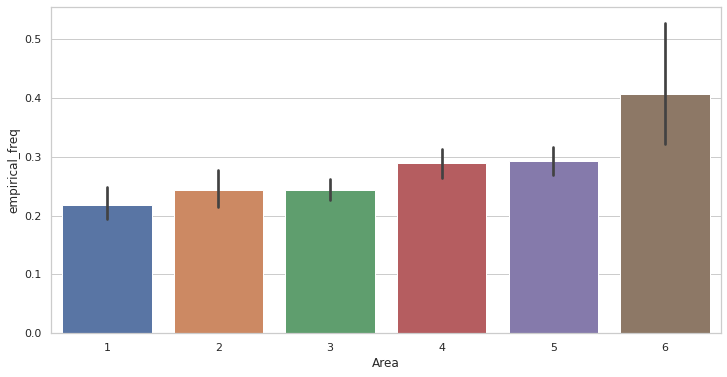

In [57]:
#sns.barplot(x="Area", y="empirical_freq", data=claimsdf, order=claimsdf.sort_values('empirical_freq').Area);
sns.barplot(x="Area", y="empirical_freq", data=claimsdf);

#### As we can see above, there's seem to be an ordinal value in the area code with respect to the empirical frequencies

##### REGION: Non ordinal,  22 CLASES, Que regiones?

In [20]:
claimsdf.Region.unique()

array(['R82', 'R22', 'R72', 'R31', 'R91', 'R52', 'R93', 'R11', 'R24',
       'R94', 'R83', 'R54', 'R26', 'R53', 'R73', 'R42', 'R25', 'R21',
       'R41', 'R43', 'R74', 'R23'], dtype=object)

In [21]:
dic_region = {'R11': 1, 'R21': 2, 'R22': 3, 'R23': 4, 'R24': 5, 'R25': 6, 'R26': 7, 
              'R31': 8, 'R41': 9, 'R42': 10, 'R43': 11, 'R52': 12, 'R53': 13, 'R54': 14,
              'R72': 15, 'R73': 16, 'R74': 17, 'R82': 18, 'R83': 19, 'R91': 20, 'R93': 21, 
              'R94': 22}

In [22]:
claimsdf.Region = claimsdf.Region.map(dic_region)

#### VEHICLE POWER (Ordered cathegorical according to the data source)

In [23]:
claimsdf.VehPower.unique()

array([ 5,  6,  7,  4,  9, 15,  8, 10, 12, 11, 14, 13])

In [24]:
claimsdf.VehPower.value_counts()

6     148976
7     145401
5     124821
4     115349
8      46956
10     31354
9      30085
11     18352
12      8214
13      3229
15      2926
14      2350
Name: VehPower, dtype: int64

In [25]:
def vehpower_gr(x):
    """
    ARG: A number
    Returns: If is different from 12, 13, 14 or 15, returns the number, 
    otherwise, returns 12
    """
    if x in [12, 13, 14, 15]:
        x_ = 12
        return x_
    else:
        return x

In [26]:
claimsdf['VehPower_'] = claimsdf.VehPower.apply(lambda x: vehpower_gr(x))

#### VEHICLE AGE

##### Vehicle Age and Driver Age should be cathegorized in a way such that each resulting class is as homogeneous as possible in the underlying frequency. For GLM modeling approach, as the frequencies are non-linearly related to those features, we should partition them and then treat them as (nominal) categorical variables.

In [41]:
claimsdf.VehAge.unique()

array([  0,   2,   1,   9,   8,   4,  10,   5,   3,   6,   7,  15,  25,
        29,  13,  14,  11,  12,  19,  18,  17,  16,  23,  26,  21,  20,
        37,  22,  28,  27,  24,  30,  33,  42,  31,  32,  34,  59,  38,
        39,  46,  35, 100,  43,  44,  36,  40,  78,  99,  48,  41,  47,
        45,  79,  49,  68,  80,  50,  83,  54,  64,  52,  69,  76,  81,
        51,  84,  55,  65,  53,  70,  62,  82,  85,  66,  60,  63,  71])

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


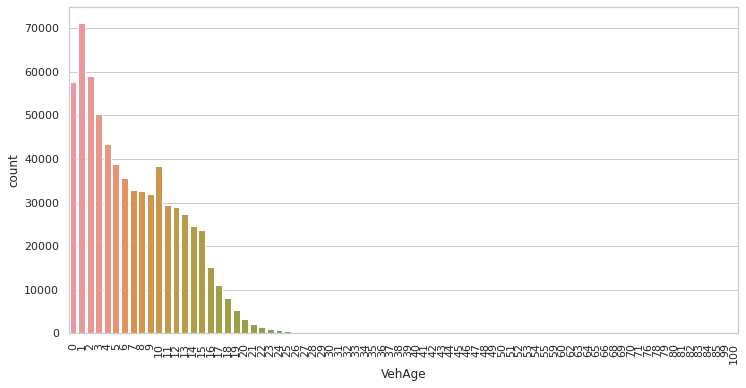

In [46]:
ax = sns.countplot(claimsdf['VehAge'])
ax.tick_params(axis='x', rotation=90);

#### As we can see in the above graph, almost all cars in the data set are under 20 years old, we will group them in 3 different classes

In [54]:
def vehage_gr(x):
    """
    ARG: A number
    Returns: If x belongs to [0,1] -> 1
             If x belongs to (1,10] -> 2
             If x belongs to (10,+inf) -> 3
    """
    if x in range(2):
        x_ = 1
        return x_
    elif x in range(1,11):
        x_ = 2
        return x_
    else:
        return 3

In [55]:
claimsdf['VehAge_'] = claimsdf.VehAge.apply(lambda x: vehage_gr(x))

#### DRIVER AGE

#### We'll repeat the same procedure for the drivers age, by grouping them in 8 different clases 

In [32]:
claimsdf.DrivAge.unique()

array([ 55,  52,  46,  38,  33,  41,  56,  27,  23,  44,  32,  73,  59,
        54,  69,  60,  43,  50,  30,  45,  40,  37,  28,  67,  62,  61,
        42,  51,  53,  31,  65,  47,  75,  39,  22,  24,  48,  26,  49,
        35,  29,  58,  74,  36,  76,  70,  34,  66,  63,  71,  57,  72,
        25,  68,  64,  79,  78,  77,  20,  18,  21,  80,  19,  87,  81,
        95,  86,  84,  88,  83,  90,  93,  82,  85,  91,  89,  99,  94,
        92,  96,  97,  98, 100])

/home/julian/miniconda3/envs/ironcon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


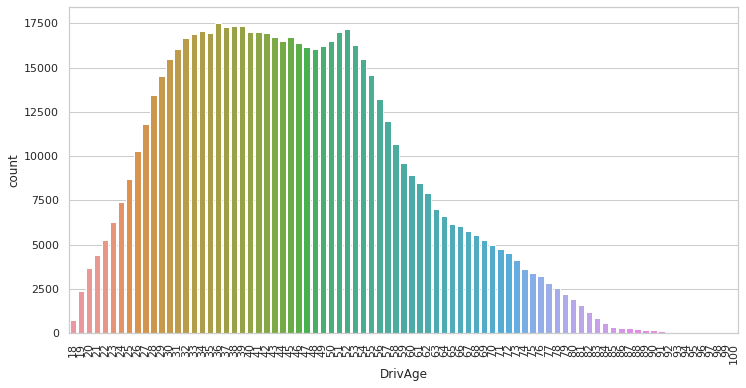

In [58]:
ax = sns.countplot(claimsdf.DrivAge)
ax.tick_params(axis='x', rotation=90);

In [64]:
def drivage_gr(x):
    """
    ARG: A number
    Returns: Assings a class (from 1 to 8) if x belongs to the specified ranges
    """
    if x in range(18,21):
        x_ = 1
        return x_
    elif x in range(21,26):
        x_ = 2
        return x_
    elif x in range(26,31):
        x_ = 3
        return x_
    elif x in range(31,41):
        x_ = 4
        return x_
    elif x in range(41,51):
        x_ = 5
        return x_
    elif x in range(51,61):
        x_ = 6
        return x_
    elif x in range(61,71):
        x_ = 7
        return x_

    else:
        return 8

In [70]:
claimsdf['DrivAge_'] = claimsdf.DrivAge.apply(lambda x: drivage_gr(x))

In [72]:
claimsdf.drop(columns=['VehPower', 'VehAge', 'DrivAge'], inplace=True)

In [73]:
claimsdf.head()

,IDpol,ClaimNb,Exposure,Area,BonusMalus,VehBrand,Density,Region,empirical_freq,VehGas_Regular,VehPower_,VehAge_,DrivAge_
0,1.0,1,0.10,4,50,9,1217,18,10.000000,1,5,1,6
1,3.0,1,0.77,4,50,9,1217,18,1.298701,1,5,1,6
2,5.0,1,0.75,2,50,9,54,3,1.333333,0,6,2,6
3,10.0,1,0.09,2,50,9,76,15,11.111111,0,7,1,5
4,11.0,1,0.84,2,50,9,76,15,1.190476,0,7,1,5


### VARIABLES CONTINUAS 

#### DENSITY

In [ ]:
claimsdf.Density.value_counts()

#### BONUSMALUS, expresado en que unidades?

In [ ]:
claimsdf.BonusMalus.unique()

In [ ]:
claimsdf.BonusMalus.value_counts()